[Link to this document's Jupyter Notebook](./0415-PROJECT_Part2.ipynb)

# Part 2 - Optimizing Deep Learning with PyTorch Lightning 

By Sai Ramesh

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F648%2F1*MnqNaWFaAmQTrJs0tuvpDQ.jpeg&f=1&nofb=1" alt="Just a simple camera icon intended to be replaced with your image" width="50%">

Image from: https://miro.medium.com/max/648/1*MnqNaWFaAmQTrJs0tuvpDQ.jpeg

---
# Abstract

This project focuses on optimizing PyTorch code to predict TF binding sites using DNA sequences only. The input data is the coordinates of the DNA fragments; first we get the sequences (‘ATGC’) of the fragments and encode them as a 4xn matrix. The label of each fragment is a vector, and each dimension shows whether the fragment is bound by one TF and there are totally 128 TFs. The model is a **convolutional neural network** with 1 convolutional layer, 2 dilated convolutional layers, and 1 fully connected layer that outputs the predicted labels.


My goal with this project is speeding up the training/testing of the neural network (ideally by 33-50%), which is already making use of a single GPU. Over the course of the project, I optimizing the code on one GPU and then eventually distribute the process over multiple GPUs. I make heavy use of module called **PyTorch Lightning** to achieve these goals.


---
# Methodology

**PyTorch Lightning** is really a way of better organizing your PyTorch code as opposed to a completely new framework. 

All of the "meat" of your PyTorch code goes into the `LightningModule`, which organizes your code into 5 sections: 

- Computations (init).

- Train loop (training_step)

- Validation loop (validation_step)

- Test loop (test_step)

- Optimizers (configure_optimizers)



The original code had a for loop that looped through each of the epochs and trained/validated each step, and initialized an Adam optimizer to train the model. 

When I refactored the PyTorch code to Lightning, I put this training/validation loop along with the Adam optimizer into three separate methods in the model class (`training_step`, `validation_step`, and `configure_optimizers` in the `lightning_network_model.py` file). This makes the code a lot easier to debug (because you're not writing the loop yourself and copying back and forth from the GPU). Lightning does a lot of optimizations behind the scenes that lead to better performance, as we'll see in the rest of the report!


### How to reproduce the code:

First, you'll have to install `conda`. Follow the instructions from : https://docs.anaconda.com/anaconda/install/linux/

Next, navigate to the `final_project_results` directory and type `make`. This will set up the proper conda environment to run tests. 


In order to test the Lightning code, type `make lightning_test`. In order to test the base PyTorch code, type `make torch_test`. These two commands will both submit jobs to the queue. You can toggle with the number of GPUs and nodes in the `run_lightning.sh` and `run_base_torch.sh` scripts.

In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

---
# Timing Results



## Part 1- Identifying the bottleneck

The key to any speeding up your code is knowing **where** to focus your efforts. For deep neural networks, the bulk of the time almost always goes towards training the model. But I wanted to make sure that was the case. 

The barplot below provides the average time of execution for the **train** and **test** steps, as well as for the epoch as a whole.

In [15]:
from statistics import mean

def avg_time(file_name: str):
    with open(file_name, "r") as f:
        times = (float(line) for line in f)
        return mean(times)

Text(0.5, 1.0, 'Average Execution Time of Each Step')

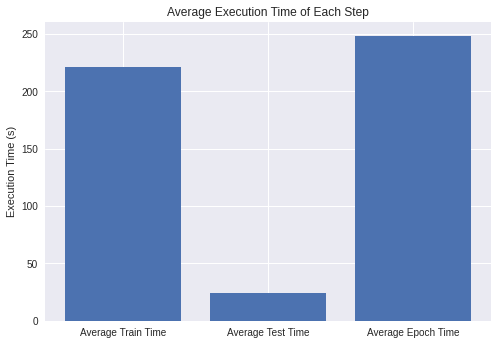

In [19]:
train_avg = avg_time("./second_test/train_times.txt")
test_avg = avg_time("./second_test/test_times.txt")
total_epoch = 36000 / 145 # got this value from the execution time of the job (10 hours) in seconds divided by the number of epochs completed (145) 

time_list = [train_avg, test_avg, total_epoch]
labels = ["Average Train Time", "Average Test Time", "Average Epoch Time"]
plt.bar(labels, time_list)
plt.ylabel("Execution Time (s)")
plt.title("Average Execution Time of Each Step")

As expected, the bulk of the execution time goes towards the training. The average execution time of each epoch is almost exactly equal to the sum of the average train time and the average test time, which is also good news; it means that there are no unexpected bottlenecks slowing the process down. 

With this in mind, let's proceed to the next step- refactoring the code using PyTorch Lightning.

## Part 2-  Baseline Experiment

### Vanilla PyTorch code vs. PyTorch Lightning, both on 1 GPU

I refactored the base PyTorch code into Lightning style by getting rid of the training loop and replacing it with two methods within the network model class (one for the training step and one for the validation step). This barplot compares the minutes per epoch for both versions of the code.

Text(0.5, 1.0, 'Timing Comparison between PyTorch and PyTorch Lightning- 1 GPU')

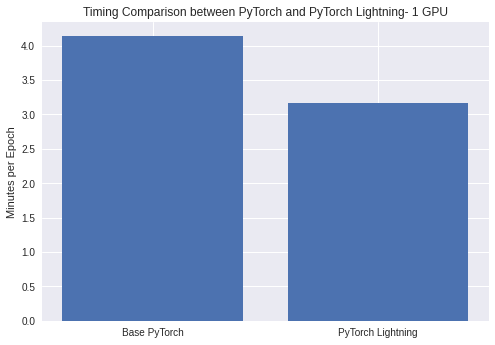

In [20]:

# timing vals are from second_output/epoch_times.txt and the the slurm output in the third_output/ directory
base_pytorch_baseline = 600 / 145  # same calculation as the epoch avg in the above plot, but in minutes instead of seconds
lightning_minutes = 10*60 + 34 + 21/60 # calculation comes from the execution time (10:34:21) in minutes.
lightning_baseline = lightning_minutes / 200  # execution time divided by the number of epochs completed

baseline_times = [base_pytorch_baseline, lightning_baseline]

plt.bar(["Base PyTorch", "PyTorch Lightning"], [base_pytorch_baseline, lightning_baseline])
plt.ylabel("Minutes per Epoch")
plt.title("Timing Comparison between PyTorch and PyTorch Lightning- 1 GPU")

These are promising results! On just a single GPU, Lightning provides a **23.3%** speedup. This is substantial and very encouraging, especially since there's less of a threat of needing more time to schedule the job because both of these single GPU jobs require the same amount of resources. Naturally, I was very encouraged to see this and was excited to distribute the job over multiple GPUs (a task which is quite trivial in PyTorch Lightning). However, the reality was a little more disappointing here...

### Single Node, Multiple GPUs

Text(0.5, 1.0, 'Execution Time of PyTorch Lightning Code- Multiple GPUs, Single Node')

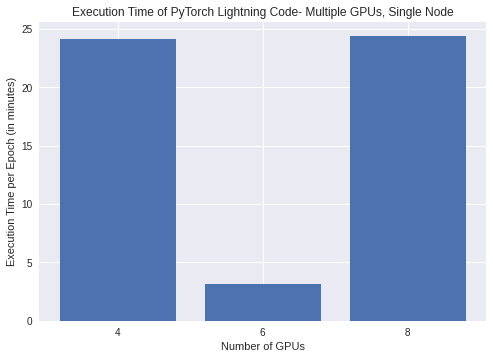

In [31]:
# these are jobs with a 3:59:00 time limit 
time_in_minutes = 3 * 60 + 59
# the three calculations below come from the job execution time divided by the epochs completed
nodes_1_gpus_8 = time_in_minutes / 9.8
nodes_1_gpus_6 = time_in_minutes / 74.95
nodes_1_gpus_4 = time_in_minutes / 9.89

node_1_multiple_gpus = [ nodes_1_gpus_4, nodes_1_gpus_6, nodes_1_gpus_8]
plt.bar(["4", "6", "8"], node_1_multiple_gpus)
plt.xlabel("Number of GPUs")
plt.ylabel("Execution Time per Epoch (in minutes)")
plt.title("Execution Time of PyTorch Lightning Code- Multiple GPUs, Single Node")

These results are... off. 4 GPUs and 8 GPUs lead to a massive ~24 minute runtime for each epoch, 6 times as much as . On the other hand, 6 GPUs leads to a run time of 3.18 minutes per epoch, which is faster than the vanilla PyTorch but still slightly slower than Lightning on a single GPU. It is also important to note that these jobs each took several hours to start running. That should definitely be factored into the total runtime. 

What this tells me is that distributing the job over multiple GPUs on a single node is unpredictable at best and catastrophically slow at worst. I don't know if it was purely because of the additional overhead needed to distribute the job, or if it was an issue with SLURM (because I tested running the script with multiple GPUs on the command line and it seemed to run at around 3 minutes per epoch for the first 5 epochs or so), but either way, there's an issue here. But what if we ran it on multiple nodes as well as multiple GPUs?

### Multiple Nodes, Multiple GPUs


Here, I ran into a major problem. It was easy enough to change the parameters of the `lightning_TF_train.py` file to ensure that multi GPU training was possible. It was also easy enough to modify the slurm submission script to request multiple GPUs on multiple nodes. The problem was that the job took *forever* to schedule. When they finally did end up running, the code threw an exception because the amount of memory I requested (25 GB) was insufficient. I increased the memory request to 50 GB, but naturally, that took even longer to schedule (I waited overnight and they still had not started to run).

That's why I decided to scrap this part of the project, mainly because of the practical implications of how long these jobs were taking to schedule. The whole point of this project is to find a way to speed up this process, and waiting hours upon hours for the code to even start running runs counter to that goal. Even if the multi-node process led to performance gains (unclear if that would be the case due to my experiences with multiple GPUs on a single node), it almost definitely would be outweighed by the eons it took to schedule.

---
# Concluding Discussion and Future Work

### Conclusions:

- **Job scheduling time matters. A lot.** 
    - Scheduling jobs on the HPCC (especially with many GPUs and many nodes) is an absolute pain. While it's true that running on multiple GPUs _may_ lead to a speedup, those jobs may take hours to schedule and rob you of any gains. Especially for a big job like this, it might just be worth it to run on a single GPU with PyTorch Lightning.
- **Lightning on its own is pretty great**
    - Even ignoring the possibility of training on multiple GPUs, a single GPU Lightning program leads to a pretty substantial speedup (23.3%). This is great for two reasons:
    
    1) **Training on multiple GPUs seems to be tricky** (especially with the scheduling time added). It's good to see that a job with one GPU that will take just as much time to schedule as a vanilla PyTorch job still produces noticeable speed gains.
    
    2) **PyTorch Lightning code is a lot cleaner and more readable.** Lightning was designed as a way of better organizing PyTorch code. The optimizations that come with it are great, but arguably the best feature of the module is making your code better. You no longer have to write your own loop to train and validate your model. You no longer have to manually copy to and from the GPU devices. This aids greatly in decreasing **development time**, which is often more important than computational time.

- **Multi GPU training often adds unexplained overhead.**
    - Training on 2-4 GPUs leads to overhead that far outweighs any potential gain. 6 GPUs seems to be similar to the raw Lightning code and oddly enough 8 GPUs was much closer to the 2-4 GPU camp. 


**The big takeaway is that with or without training on multiple GPUs, PyTorch Lightning is absolutely worth using.** A PyTorch project that uses Lightning is not only better structured but better optimized. While I didn't quite reach my goal of a 33% speedup, I'm very pleased to have familiarized myself with this cool new module over the course of this project.

### Future work:


- **Modifying model architecture** - One thing I left rather untouched was the actual structure of the model. I may not be totally versed with the underlying biology but I do have at least a cursory grasp of how the current model structure works. It may be worth discussing if this model architecture (1 conv layer, 2 dilation conv net layers, 1 fully connected layer) is the optimal model for prediction. 
    - Could we add another layer to the model? 
    - Could we remove a layer or some the units without losing much in the way of performance (thereby saving some computational cost)? 
   This might be worth thinking about.


- **Further experimentation with other accelerator types**
    - I used the Distributed Data Parallel accelerator; it may be worth taking a look at the other recommended accelerator (Horovod) and see if that performs any better.

---
# References

PyTorch Lightning Documentation Pages:

https://pytorch-lightning.readthedocs.io/en/latest/starter/converting.html

https://pytorch-lightning.readthedocs.io/en/latest/clouds/slurm.html?highlight=slurm

https://pytorch-lightning.readthedocs.io/en/stable/advanced/multi_gpu.html

-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----